# Import Libraries

This part of code will import all the necessary libraries required for the code

In [1]:
# from BhuDM import *
# from utils import *

from pyDTDM import *
import warnings
import yaml
try:
    from yaml import Cloader as Loader
except ImportError:

    from yaml import Loader

import ptt
import shapely
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

from geopy.distance import geodesic
from geopy import Point as GeopyPoint


# Load Input File

The input file can be changed to include other parameters as well

In [6]:
config_file="phase2_paleotopography.yaml"
with open(config_file) as f:
    PARAMS = yaml.load(f, Loader=Loader)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(" Parameters set from %s" % config_file)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
 Parameters set from phase2_paleotopography.yaml
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Reading the input file

In [7]:
# Input Files 
MODEL_NAME=PARAMS['InputFiles']['plate_kinematics']['model_name'] # model name
MODEL_DIR = PARAMS['InputFiles']['plate_kinematics']['model_dir']  ## plate model location
topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['topology_files']]
rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['plate_kinematics']['rotation_files']]
agegrid=PARAMS['InputFiles']['plate_kinematics']['agegrid'] ## agegrid location

ETOPO_FILE=PARAMS['InputFiles']['Raster']['ETOPO_FILE'] # ETOPO grid in meters (can be netCDf or GeoTiff)
ETOPO_Type=PARAMS['InputFiles']['Raster']['Raster_type']
coastlines = f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['coastline_file']}"
static_polygon_file=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['static_polygon']}"
static_polygons = pygplates.FeatureCollection(static_polygon_file)
continents=f"{MODEL_DIR }/{PARAMS['InputFiles']['plate_kinematics']['continents']}"
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Plate Model: {MODEL_NAME} \n")
print(f"Model Directory: {MODEL_DIR} \n")
print(f"Coastlines: {coastlines} \n")
print(f"Continents: {continents} \n")
print(f"Static Polygons: {static_polygon_file} \n")
print(f"Model Agegrid: {agegrid} \n")
print(f"ETopo grid: {ETOPO_FILE}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Plate Model: phase2 

Model Directory: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2 

Coastlines: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/StaticGeometries/Coastlines/Global_coastlines_low_res.shp 

Continents: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentsOnly.shp 

Static Polygons: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons.shp 

Model Agegrid: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC 

ETopo grid: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/

### Setting model parameters

In [8]:
Paleomag_ID=PARAMS['Parameters']['paleomag_id']
Mantle_ID=PARAMS['Parameters']['mantle_optimised_id']

#The initial positions of crustal points are evenly distributed within the designated region. 
# At mesh refinement level zero, the points are approximately 20 degrees apart.
# Each increase in the density level results in a halving of the spacing between points.
MESH_REFINEMENT_LEVEL=PARAMS['Parameters']['mesh_refinement_level']  # higher refinement level will take longer time to run for optimisation 
WINDOW_SIZE=PARAMS['Parameters']['time_window_size']
Weighted=PARAMS['Parameters']['weighted_mean']


NETCDF_GRID_RESOLUTION=PARAMS['GridParameters']['grid_spacing']  # in degree
ZLIB=PARAMS['GridParameters']['compression']['zlib'] 
COMPLEVEL=PARAMS['GridParameters']['compression']['complevel'] 

FROM_TIME=int(PARAMS['TimeParameters']['time_max'])
TO_TIME=int(PARAMS['TimeParameters']['time_min'])
TIME_STEPS=int(PARAMS['TimeParameters']['time_step'])




parallel=PARAMS['Parameters']['number_of_cpus']### No of core to use or None for single core


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("The following parameters are set-")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Optmised Reference Frame ID: {Mantle_ID}")
print(f"Paleomagnetic Reference Frame ID: {Paleomag_ID} \n")

print(f"Moving Window Size: {WINDOW_SIZE}")
print(f"Weighted Mean: {Weighted}")

print(f"Mesh Refinement Level: {MESH_REFINEMENT_LEVEL}")
print(f"NetCDF GRID Resolution: {NETCDF_GRID_RESOLUTION}")
print(f"NetCDF Compression Level: {COMPLEVEL} \n")
print(f"Model Start Time: {FROM_TIME}")
print(f"Model End Time: {TO_TIME}")
print(f"Model Time Step: {TIME_STEPS}\n")


print(f"Number of CPU: {parallel}") # -1 means all the freely available CPU


print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
The following parameters are set-
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Optmised Reference Frame ID: 702702
Paleomagnetic Reference Frame ID: 0 

Moving Window Size: 25
Weighted Mean: True
Mesh Refinement Level: 9
NetCDF GRID Resolution: 0.1
NetCDF Compression Level: 5 

Model Start Time: 200
Model End Time: 10
Model Time Step: 1

Number of CPU: -1
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


### Creating Output File

The output will be stored in the output folder: Paleotopography

There will be two folder:
- CSV Folder: to store data in tabular format. Here I have used paraquet file because it reduces the storage 
- NetCDF Folder: to store final NetCDF that can be visualised in GPlates


In [9]:
# Output Directory
OUTPUT_FOLDER=PARAMS['OutputFiles']['output_dir']

DEFAULT_OUTPUT_CSV=os.path.join(OUTPUT_FOLDER,'CSV')  # folder to store output in Tabular format
DEFAULT_OUTPUT_NetCDF=os.path.join(OUTPUT_FOLDER,'NetCDF') # folder to store output NetCDF grid





print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"All the output will be saved in {OUTPUT_FOLDER}")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
create_directory_if_not_exists(OUTPUT_FOLDER)
create_directory_if_not_exists(DEFAULT_OUTPUT_CSV)
create_directory_if_not_exists(DEFAULT_OUTPUT_NetCDF)
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")


––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
All the output will be saved in /Volumes/Satyam/Paleotopography
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 


# Define Plate Reconstruction

class PlateKinematicsParameters can be used to define plate kinematics parameters. To know more about class you can use `help` functions. For e.g. help(PlateKinematicsParameters) 

In [10]:

PK=PlateKinematicsParameters(topology_filenames, 
                             rotation_filenames,
                             static_polygons,
                             agegrid=agegrid,
                             coastlines=coastlines,
                             continents=continents,
                             anchor_plate_id=Mantle_ID)

time = 0 #Ma
gplot = gplately.PlotTopologies(PK.model, coastlines=coastlines, continents=continents, time=time) ##gplately plotting object


RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


# Tessellate Subduction Zone and fetch associated parameters

This section of the code tessellates all the subduction zones in point and calculates all the associated subduction parameters using  PlateKinematicsParameters.get_subductiondf() function. All these are saved as parquet file.So you don't need to run this block again and again

In [11]:
# list_subduction_df=[]
# for reconstruction_time in range (TO_TIME,FROM_TIME+WINDOW_SIZE+1):
#     if reconstruction_time%50==0:
#         print(f"Tessellating Subduction at time= {reconstruction_time} Ma")
    
#     subduction_df=PK.get_subductiondf(reconstruction_time,  
#                                       tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
#                                       velocity_delta_time=TIME_STEPS)
#     subduction_df["Time"]=reconstruction_time
#     list_subduction_df.append(subduction_df)

# all_sz_df=pd.concat(list_subduction_df)
# all_sz_df.to_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet")

#### Read the subduction file once all subduction zone has been tessellated 

In [12]:
all_sz_df=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/ALL_Subduction.paraquet") 

In [13]:

create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma")

for reconstruction_time in range(TO_TIME,FROM_TIME+1,TIME_STEPS):

    if reconstruction_time%3!=0:
        continue
  
   


    training_df=PK.create_points_around_trench(all_subduction_df=all_sz_df,reconstruction_time=reconstruction_time,
                                   tessellation_threshold_deg=NETCDF_GRID_RESOLUTION,
                                   mesh_refinement_level=MESH_REFINEMENT_LEVEL)
    TrainingData=PK.get_plate_kinematics(training_df,all_sz_df,
                                         reconstruction_time=int(reconstruction_time),
                                         # window_size=int(1),
                                         window_size=int(WINDOW_SIZE),
                                         weighted_mean=Weighted,
                                         n_jobs=parallel, 
                                        # timesteps=TIME_STEPS,
                                         timesteps=5,
                                         refinement_levels=MESH_REFINEMENT_LEVEL,
                                         tessellation_threshold_deg=NETCDF_GRID_RESOLUTION)
    
    TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/Data_{reconstruction_time}.parquet")
   
    print("Done!")


Working on time=0 Ma
Adding time:
0 Ma
5 Ma
10 Ma
15 Ma
20 Ma
25 Ma
Calculating Trench Distance
Done!
Working on time=3 Ma
Adding time:
3 Ma
8 Ma
13 Ma
18 Ma
23 Ma
28 Ma
Calculating Trench Distance
Done!
Working on time=6 Ma
Adding time:
6 Ma
11 Ma
16 Ma
21 Ma
26 Ma
31 Ma
Calculating Trench Distance
Done!
Working on time=9 Ma
Adding time:
9 Ma
14 Ma
19 Ma
24 Ma
29 Ma
34 Ma
Calculating Trench Distance
Done!
Working on time=12 Ma
Adding time:
12 Ma
17 Ma
22 Ma
27 Ma
32 Ma
37 Ma
Calculating Trench Distance
Done!
Working on time=15 Ma
Adding time:
15 Ma
20 Ma
25 Ma
30 Ma
35 Ma
40 Ma
Calculating Trench Distance
Done!
Working on time=18 Ma
Adding time:
18 Ma
23 Ma
28 Ma
33 Ma
38 Ma
43 Ma
Calculating Trench Distance
Done!
Working on time=21 Ma
Adding time:
21 Ma
26 Ma
31 Ma
36 Ma
41 Ma
46 Ma
Calculating Trench Distance
Done!
Working on time=24 Ma
Adding time:
24 Ma
29 Ma
34 Ma
39 Ma
44 Ma
49 Ma
Calculating Trench Distance
Done!
Working on time=27 Ma
Adding time:
27 Ma
32 Ma
37 Ma
42 Ma
47 Ma


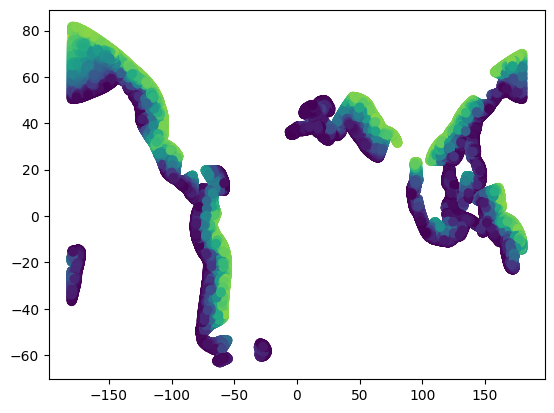

In [20]:
# plt.scatter(TrainingData['Longitude'],TrainingData['Latitude'],c=TrainingData['Trench Distance'])

In [16]:
# TrainingData


 # Calculated Mean Subduction Parameters 
The unprocessed file with be save it as .parquet file. This will take a lot of time when run at high resolution

In [11]:
# all_times

In [ ]:
Data=PK.create_points_around_trench(self,reconstruction_time, 
                            all_subduction_df,
                            threshold_distance_in_kms=1400, 
                            tessellation_threshold_deg=0.1,
                           mesh_refinement_level=9)


In [16]:
if Weighted:
    create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/WMA_{WINDOW_SIZE}Ma")
else:
    create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Mean_{WINDOW_SIZE}Ma")

for reconstruction_time in range(TO_TIME+2,FROM_TIME+1,TIME_STEPS):
    if reconstruction_time<3:
        continue

    if reconstruction_time%4==0:
        continue
    if reconstruction_time%2!=0:
        continue
        
    TrainingData=PK.get_mean_subduction(all_sz_df,
                                        reconstruction_time=int(reconstruction_time),
                                        # window_size=int(10),
                                        window_size=int(WINDOW_SIZE),
                                        weighted_mean=Weighted,
                                        n_jobs=parallel, 
                                        timesteps=TIME_STEPS,
                                        # timesteps=5,
                                        refinement_levels=MESH_REFINEMENT_LEVEL,
                                        tessellation_threshold_deg=NETCDF_GRID_RESOLUTION)
    
    if Weighted:
        TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/WMA_{WINDOW_SIZE}Ma/Data_{reconstruction_time}.parquet")
    else:
        TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Mean_{WINDOW_SIZE}Ma/Data_{reconstruction_time}.parquet")

    print("Done!")


Working on time=6 Ma
Adding time:
6 Ma
11 Ma
16 Ma
21 Ma
26 Ma
31 Ma
36 Ma
41 Ma
46 Ma
51 Ma
56 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-6.nc for agegrid
Calculating Trench Distance
Done!
Working on time=10 Ma
Adding time:
10 Ma
15 Ma
20 Ma
25 Ma
30 Ma
35 Ma
40 Ma
45 Ma
50 Ma
55 Ma
60 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-MantleReferenceFrame-10.nc for agegrid
Calculating Trench Distance
Done!
Working on time=14 Ma
Adding time:
14 Ma
19 Ma
24 Ma
29 Ma
34 Ma
39 Ma
44 Ma
49 Ma
54 Ma
59 Ma
64 Ma
Using file /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2/EarthByte_Plate_Motion_Model-Phase2-SeafloorAgeGrids-MantleFrame-NC/EarthByte_Plate_Motion_Model-Phase2-Mantl

# Define Mantle Convection Parameters

This section of code will read all the input parameters for mantle convection model

In [10]:
# Input Files 
MANTLE_MODEL_NAME=PARAMS['InputFiles']['mantle_convection']['model_name']
MANTLE_MODEL_DIR = PARAMS['InputFiles']['mantle_convection']['model_dir']  ## plate model
MANTLE_topology_filenames =[f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['mantle_convection']['topology_files']]
MANTLE_rotation_filenames = [f"{MODEL_DIR}/{i}" for i in PARAMS['InputFiles']['mantle_convection']['rotation_files']]

MANTLE_depths= PARAMS['InputFiles']['mantle_convection']['depth']
MANTLE_vel_folder=PARAMS['InputFiles']['mantle_convection']['new_vel_folder']
MANTLE_temp_folder=PARAMS['InputFiles']['mantle_convection']['new_temp_folder']

MANTLE_org_vel=PARAMS['InputFiles']['mantle_convection']['original_vel_folder']
MANTLE_org_temp=PARAMS['InputFiles']['mantle_convection']['original_temp_folder']


MANTLE_velx_folder=PARAMS['InputFiles']['mantle_convection']['new_velx_folder']
MANTLE_org_velx=PARAMS['InputFiles']['mantle_convection']['original_velx_folder']

MANTLE_vely_folder=PARAMS['InputFiles']['mantle_convection']['new_vely_folder']
MANTLE_org_vely=PARAMS['InputFiles']['mantle_convection']['original_vely_folder']

MANTLE_visc_folder=PARAMS['InputFiles']['mantle_convection']['new_visc_folder']
MANTLE_org_visc=PARAMS['InputFiles']['mantle_convection']['original_visc_folder']

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print("Reading input file..... \n")
print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– ")
print(f"Mantle Convection Plate Model: {MANTLE_MODEL_NAME} \n")
print(f"Mantle Convection Plate Model Directory: {MANTLE_MODEL_DIR} \n")

print(f"Mantle Convection Velocity: {MANTLE_vel_folder} \n")
print(f"Mantle Convection Temperature: {MANTLE_temp_folder} \n")

print(f"Mantle Convection Velocity: {MANTLE_org_vel} \n")
print(f"Mantle Convection Temperature: {MANTLE_org_temp} \n")

print(f"Mantle Convection Depths: {MANTLE_depths} \n")

print("––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– \n")

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Reading input file..... 

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––– 
Mantle Convection Plate Model: phase2 

Mantle Convection Plate Model Directory: /Users/ssin4735/Documents/PROJECT/PhD Project/Codes and Data/Phase2 

Mantle Convection Velocity: /Volumes/Satyam/Paleotopography/STLR1GaM5/vz_dimensional 

Mantle Convection Temperature: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional 

Mantle Convection Velocity: /Volumes/Satyam/STLR1GaM5/vz_dimensional 

Mantle Convection Temperature: /Volumes/Satyam/STLR1GaM5/temp_dimensional 

Mantle Convection Depths: [16, 31, 47, 62, 140, 155, 171, 186, 202, 217, 233, 268, 293, 323, 357, 396, 439, 487, 540, 597, 660, 726, 798, 874, 954, 1040, 1130, 1224, 1324, 1428, 1536, 1639, 1737, 1830, 1916, 1998, 2074, 2145, 2210, 2270, 2324, 2373, 2416, 2454, 2487, 2514, 2541, 2568, 2595, 2623, 2650, 2677, 2704, 2731, 2758, 2785, 2813, 2849, 2867]

In [13]:
MT=MantleParameters(original_folder=MANTLE_org_temp,
                    new_folder=MANTLE_temp_folder,
                    parameter_type="Mantle_Temp", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)
VZ=MantleParameters(original_folder=MANTLE_org_vel,
                    new_folder=MANTLE_vel_folder,
                    parameter_type="Mantle_Velocity", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vz_dimensional
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'


In [14]:
VX=MantleParameters(original_folder=MANTLE_org_velx,
                    new_folder=MANTLE_velx_folder,
                    parameter_type="Mantle_Velocity_X", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

VY=MantleParameters(original_folder=MANTLE_org_vely,
                    new_folder=MANTLE_vely_folder,
                    parameter_type="Mantle_Velocity_Y", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

VISC=MantleParameters(original_folder=MANTLE_org_visc,
                    new_folder=MANTLE_visc_folder,
                    parameter_type="Viscocity", 
                    depths=MANTLE_depths, 
                    starttime=TO_TIME,
                    endtime=FROM_TIME,
                    timestep=TIME_STEPS, 
                    anchor_plate_id=Mantle_ID)

Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc
Rotation File not provided!
Topologies not provided
'MantleParameters' object has no attribute 'rotation_model'


### Interpolate Mantle Convection Data at each timesteps.

In case you don't have mantle parameters at uniform time step you can use a linear interpolation. Note that this will create a huge amount of data


In [15]:
MT.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)
VZ.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/11
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/12
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/13
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/14
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 10 Ma to 15 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/16
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/17
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/18
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/19
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 15 Ma to 20 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/temp_dimensional/21
Created dir

In [16]:
VX.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/11
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/12
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/13
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/14
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 10 Ma to 15 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/16
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/17
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/18
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/19
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 15 Ma to 20 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vx_dimensional/21
Created directory: /Volumes/S

In [17]:
VY.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/11
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/12
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/13
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/14
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 10 Ma to 15 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/16
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/17
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/18
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/19
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 15 Ma to 20 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/vy_dimensional/21
Created directory: /Volumes/S

In [18]:
VISC.interpolate_mantle_data(n_jobs=parallel,required_timesteps=TIME_STEPS)

Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/11
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/12
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/13
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/14
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 10 Ma to 15 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/16
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/17
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/18
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/19
No raster file for interpolating {d} from {start_time} Ma to {end_time} Ma
Interpolation completed from 15 Ma to 20 Ma completed.
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/21
Created directory: /Volumes/Satyam/Paleotopography/STLR1GaM5/visc/22
Created directory: /Volumes/Satyam/Paleotopography

# Define Climate Parameters
This section will create climate parameters such as time a location spent in humid belt. Unlike other Plate Kinematics and Mantle convection parameters which are calculated in mantle reference frame. The climate parameter is calculated in Paleomag Reference Frame 

In [20]:
CM=ClimateParameters(topology_filenames, 
                             rotation_filenames,
                             static_polygons,
                             agegrid=agegrid,
                             coastlines=coastlines,
                             continents=continents,
                             anchor_plate_id=Paleomag_ID)



RotationModel: No filename associated with <class 'pygplates.pygplates.RotationModel'> in __init__
 ensure pygplates is imported from gplately. Run,
 from gplately import pygplates


# Extract Mantle Convection and Climate Parameters

This section of code will first read the data generated by PlateKinematics and then sample mantle parameters at every location. It will also track the point to calculate time a location spend in Humid Belt

In [19]:
all_times=glob.glob(f"{DEFAULT_OUTPUT_CSV}/Window_Size_{WINDOW_SIZE}_Ma/*")
all_times=np.sort([int(time.split('_')[-1].split('.')[0]) for time in all_times])

In [20]:
# if Weighted:
create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma")

# reconstruction_time=0
for reconstruction_time in all_times:
# for reconstruction_time in range(0,525):
    try:
        
    
        print(f"Getting Data at time={reconstruction_time} Ma")
        TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
        TrainingData=VY.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle temp
        TrainingData=VX.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting vertical mantle vel
        TrainingData=VISC.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel)
        # TrainingData=CM.get_time_spent_in_humid_belt(PK.model,TrainingData,reconstruction_time=0,window_size=15,lat_band=10,use_trench=True,
        #                                         drop_fraction =0.8)
        
        
        TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_{WINDOW_SIZE}_Ma/Processed_Data_{reconstruction_time}.parquet")
       
        print("Processed and saved data!")

    except Exception as e:
        print(f"Error={e}")



Getting Data at time=0 Ma
Processed and saved data!
Getting Data at time=3 Ma
Processed and saved data!
Getting Data at time=6 Ma
Processed and saved data!
Getting Data at time=9 Ma
Processed and saved data!
Getting Data at time=12 Ma
Processed and saved data!
Getting Data at time=15 Ma
Processed and saved data!
Getting Data at time=18 Ma
Processed and saved data!
Getting Data at time=21 Ma
Processed and saved data!
Getting Data at time=24 Ma
Processed and saved data!
Getting Data at time=27 Ma
Processed and saved data!
Getting Data at time=30 Ma
Processed and saved data!
Getting Data at time=33 Ma


Processed and saved data!
Getting Data at time=36 Ma
Processed and saved data!
Getting Data at time=39 Ma
Processed and saved data!
Getting Data at time=42 Ma
Processed and saved data!
Getting Data at time=45 Ma
Processed and saved data!
Getting Data at time=48 Ma
Processed and saved data!
Getting Data at time=51 Ma
Processed and saved data!
Getting Data at time=54 Ma
Processed and saved data!
Getting Data at time=57 Ma
Processed and saved data!
Getting Data at time=60 Ma
Processed and saved data!
Getting Data at time=63 Ma
Processed and saved data!
Getting Data at time=66 Ma
Processed and saved data!
Getting Data at time=69 Ma
Processed and saved data!
Getting Data at time=72 Ma
Processed and saved data!
Getting Data at time=75 Ma
Processed and saved data!
Getting Data at time=78 Ma
Processed and saved data!
Getting Data at time=81 Ma
Processed and saved data!
Getting Data at time=84 Ma
Processed and saved data!
Getting Data at time=87 Ma
Processed and saved data!
Getting Data at time

Processed and saved data!
Getting Data at time=327 Ma
Processed and saved data!
Getting Data at time=330 Ma
Processed and saved data!
Getting Data at time=333 Ma
Processed and saved data!
Getting Data at time=336 Ma
Processed and saved data!
Getting Data at time=339 Ma


Processed and saved data!
Getting Data at time=342 Ma
Processed and saved data!
Getting Data at time=345 Ma
Processed and saved data!
Getting Data at time=348 Ma
Processed and saved data!
Getting Data at time=351 Ma
Processed and saved data!
Getting Data at time=354 Ma
Processed and saved data!
Getting Data at time=357 Ma


Processed and saved data!
Getting Data at time=360 Ma
Processed and saved data!
Getting Data at time=363 Ma
Processed and saved data!
Getting Data at time=366 Ma
Processed and saved data!
Getting Data at time=369 Ma
Processed and saved data!
Getting Data at time=372 Ma
Processed and saved data!
Getting Data at time=375 Ma
Processed and saved data!
Getting Data at time=378 Ma
Processed and saved data!
Getting Data at time=381 Ma


Processed and saved data!
Getting Data at time=384 Ma
Processed and saved data!
Getting Data at time=387 Ma
Processed and saved data!
Getting Data at time=390 Ma
Processed and saved data!
Getting Data at time=393 Ma
Processed and saved data!
Getting Data at time=396 Ma
Processed and saved data!
Getting Data at time=399 Ma
Processed and saved data!
Getting Data at time=402 Ma
Processed and saved data!
Getting Data at time=405 Ma
Processed and saved data!
Getting Data at time=408 Ma
Processed and saved data!
Getting Data at time=411 Ma
Processed and saved data!
Getting Data at time=414 Ma


Processed and saved data!
Getting Data at time=417 Ma


Processed and saved data!
Getting Data at time=420 Ma
Processed and saved data!
Getting Data at time=423 Ma
Processed and saved data!
Getting Data at time=426 Ma
Processed and saved data!
Getting Data at time=429 Ma
Processed and saved data!
Getting Data at time=432 Ma
Processed and saved data!
Getting Data at time=435 Ma
Processed and saved data!
Getting Data at time=438 Ma


Processed and saved data!
Getting Data at time=441 Ma
Processed and saved data!
Getting Data at time=444 Ma
Processed and saved data!
Getting Data at time=447 Ma
Processed and saved data!
Getting Data at time=450 Ma
Processed and saved data!
Getting Data at time=453 Ma
Processed and saved data!
Getting Data at time=456 Ma
Processed and saved data!
Getting Data at time=459 Ma
Processed and saved data!
Getting Data at time=462 Ma
Processed and saved data!
Getting Data at time=465 Ma
Processed and saved data!
Getting Data at time=468 Ma
Processed and saved data!
Getting Data at time=471 Ma
Processed and saved data!
Getting Data at time=474 Ma
Processed and saved data!
Getting Data at time=477 Ma
Processed and saved data!
Getting Data at time=480 Ma
Processed and saved data!
Getting Data at time=483 Ma
Processed and saved data!
Getting Data at time=486 Ma
Processed and saved data!
Getting Data at time=489 Ma
Processed and saved data!
Getting Data at time=492 Ma
Processed and saved data!
Ge

In [20]:
if Weighted:
    create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA")
else:
    create_directory_if_not_exists(f"{DEFAULT_OUTPUT_CSV}/Processed_Mean")

# reconstruction_time=0
# for reconstruction_time in all_times:
for reconstruction_time in range(0,525):
    try:
        if reconstruction_time<360:
            continue
        # if reconstruction_time%3==0:
        #     continue
        if reconstruction_time in all_times2:
            continue
    
        print(f"Getting Data at time={reconstruction_time} Ma")
        TrainingData=pd.read_parquet(f"{DEFAULT_OUTPUT_CSV}/WMA_{WINDOW_SIZE}Ma/Data_{reconstruction_time}.parquet")
        TrainingData=MT.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting mantle temp
        TrainingData=VZ.get_mantle_parameters(TrainingData,reconstruction_time, depth_wise=True,n_jobs=parallel) ## getting vertical mantle vel
        TrainingData=CM.get_time_spent_in_humid_belt(PK.model,TrainingData,reconstruction_time=0,window_size=15,lat_band=10,use_trench=True,
                                                drop_fraction =0.8)
        
        if Weighted:
            TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_WMA/Processed_Data_{reconstruction_time}.parquet")
        else:
            TrainingData.to_parquet(f"{DEFAULT_OUTPUT_CSV}/Processed_Mean/Processed_Data_{reconstruction_time}.parquet")
        print("Processed and saved data!")
    except Exception as e:
        print(f"Error={e}")



Getting Data at time=363 Ma
Processed and saved data!
Getting Data at time=365 Ma
Processed and saved data!
Getting Data at time=368 Ma
Processed and saved data!
Getting Data at time=369 Ma
Processed and saved data!
Getting Data at time=371 Ma


Processed and saved data!
Getting Data at time=372 Ma
Processed and saved data!
Getting Data at time=374 Ma
Processed and saved data!
Getting Data at time=375 Ma


Processed and saved data!
Getting Data at time=377 Ma
Processed and saved data!
Getting Data at time=378 Ma
Processed and saved data!
Getting Data at time=380 Ma
Processed and saved data!
Getting Data at time=381 Ma


Processed and saved data!
Getting Data at time=383 Ma
Processed and saved data!
Getting Data at time=384 Ma
Processed and saved data!
Getting Data at time=386 Ma
Processed and saved data!
Getting Data at time=387 Ma
Processed and saved data!
Getting Data at time=389 Ma
Processed and saved data!
Getting Data at time=390 Ma


Processed and saved data!
Getting Data at time=392 Ma


Processed and saved data!
Getting Data at time=393 Ma
Processed and saved data!
Getting Data at time=395 Ma
Processed and saved data!
Getting Data at time=396 Ma
Processed and saved data!
Getting Data at time=398 Ma
Processed and saved data!
Getting Data at time=399 Ma
Processed and saved data!
Getting Data at time=401 Ma


Processed and saved data!
Getting Data at time=402 Ma
Processed and saved data!
Getting Data at time=404 Ma
Processed and saved data!
Getting Data at time=405 Ma
Processed and saved data!
Getting Data at time=407 Ma
Processed and saved data!
Getting Data at time=408 Ma
Processed and saved data!
Getting Data at time=410 Ma
Processed and saved data!
Getting Data at time=411 Ma


Processed and saved data!
Getting Data at time=413 Ma
Processed and saved data!
Getting Data at time=414 Ma
Processed and saved data!
Getting Data at time=416 Ma
Processed and saved data!
Getting Data at time=417 Ma
Processed and saved data!
Getting Data at time=419 Ma


Processed and saved data!
Getting Data at time=420 Ma


Processed and saved data!
Getting Data at time=422 Ma


Processed and saved data!
Getting Data at time=423 Ma


Processed and saved data!
Getting Data at time=425 Ma
Processed and saved data!
Getting Data at time=426 Ma


Processed and saved data!
Getting Data at time=428 Ma
Processed and saved data!
Getting Data at time=429 Ma
Processed and saved data!
Getting Data at time=431 Ma
Error=[Errno 2] No such file or directory: 'Paleotopography/CSV/WMA_15.0Ma/Data_431.parquet'
Getting Data at time=432 Ma
Processed and saved data!
Getting Data at time=434 Ma
Processed and saved data!
Getting Data at time=435 Ma
Processed and saved data!
Getting Data at time=437 Ma
Processed and saved data!
Getting Data at time=438 Ma
Processed and saved data!
Getting Data at time=440 Ma
Processed and saved data!
Getting Data at time=441 Ma
Processed and saved data!
Getting Data at time=443 Ma
Processed and saved data!
Getting Data at time=444 Ma
Processed and saved data!
Getting Data at time=446 Ma
Processed and saved data!
Getting Data at time=447 Ma
Processed and saved data!
Getting Data at time=449 Ma
Processed and saved data!
Getting Data at time=450 Ma
Processed and saved data!
Getting Data at time=452 Ma
Processed and s

Processed and saved data!
Getting Data at time=458 Ma
Processed and saved data!
Getting Data at time=459 Ma
Processed and saved data!
Getting Data at time=461 Ma
Processed and saved data!
Getting Data at time=462 Ma
Processed and saved data!
Getting Data at time=464 Ma
Processed and saved data!
Getting Data at time=465 Ma
Processed and saved data!
Getting Data at time=467 Ma
Processed and saved data!
Getting Data at time=468 Ma


Processed and saved data!
Getting Data at time=470 Ma
Processed and saved data!
Getting Data at time=471 Ma


Processed and saved data!
Getting Data at time=473 Ma
Processed and saved data!
Getting Data at time=474 Ma
Processed and saved data!
Getting Data at time=476 Ma
Processed and saved data!
Getting Data at time=477 Ma


Processed and saved data!
Getting Data at time=479 Ma
Processed and saved data!
Getting Data at time=480 Ma


Processed and saved data!
Getting Data at time=482 Ma
Processed and saved data!
Getting Data at time=483 Ma
Processed and saved data!
Getting Data at time=485 Ma
Processed and saved data!
Getting Data at time=486 Ma
Processed and saved data!
Getting Data at time=488 Ma
Processed and saved data!
Getting Data at time=489 Ma
Processed and saved data!
Getting Data at time=491 Ma
Processed and saved data!
Getting Data at time=492 Ma
Processed and saved data!
Getting Data at time=494 Ma
Processed and saved data!
Getting Data at time=495 Ma
Processed and saved data!
Getting Data at time=497 Ma
Processed and saved data!
Getting Data at time=498 Ma
Processed and saved data!
Getting Data at time=500 Ma
Processed and saved data!
Getting Data at time=501 Ma
Processed and saved data!
Getting Data at time=503 Ma
Processed and saved data!
Getting Data at time=504 Ma
Processed and saved data!
Getting Data at time=506 Ma
Processed and saved data!
Getting Data at time=507 Ma
Processed and saved data!
Ge